# Importing the required libraries

In [1]:
import os, cv2, random, time, shutil, csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import squarify

# Finding the contents of the directory

In [2]:
files_type = {}
files_extension = {}
for dirname, _, filenames in os.walk('/root/project/data'):
    for filename in filenames:
        if '.' in filename:
            extension = filename[filename.find('.')+1:]
            files_extension[extension] = files_extension.get(extension, 0) + 1
            if extension not in files_type: files_type[extension] = []
            files_type[extension].append(os.path.join(dirname, filename))
print(files_extension)
print(files_type['csv'])

{'csv': 2, 'jpg': 20616, 'jpeg': 4, 'h5': 4}
['/root/project/data/labels.csv', '/root/project/data/.ipynb_checkpoints/labels-checkpoint.csv']


# Describing the labels

In [3]:
labels_df = pd.read_csv('/root/project/data/labels.csv')
labels_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
labels_df.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


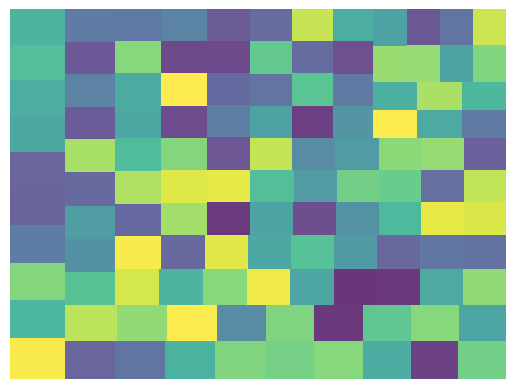

In [5]:
breed_counts = labels_df['breed'].value_counts()
breed_df = pd.DataFrame({'Breed': breed_counts.index, 'Count': breed_counts.values})
squarify.plot(sizes=breed_df['Count'], alpha=.8)
plt.axis('off')
plt.show()

In [6]:
dog_breeds = sorted(list(set(labels_df['breed'])))
n_classes = len(dog_breeds)
class_to_num = dict(zip(dog_breeds, range(n_classes)))
train_dir = '/root/project/data/train/'
test_dir = '/root/project/data/test/'